# Machine Learning Final Project 

Author: Xiaolan Li

### Required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,5)
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
import time
from sklearn.decomposition import PCA

# 1. Data Preprocessing

In [2]:
df_churn = pd.read_excel('Telco_customer_churn.xlsx')
df_churn.tail()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
7038,2569-WGERO,1,United States,California,Landers,92285,"34.341737, -116.539416",34.341737,-116.539416,Female,...,Two year,Yes,Bank transfer (automatic),21.15,1419.4,No,0,45,5306,NaN
7039,6840-RESVB,1,United States,California,Adelanto,92301,"34.667815, -117.536183",34.667815,-117.536183,Male,...,One year,Yes,Mailed check,84.80,1990.5,No,0,59,2140,NaN
7040,2234-XADUH,1,United States,California,Amboy,92304,"34.559882, -115.637164",34.559882,-115.637164,Female,...,One year,Yes,Credit card (automatic),103.20,7362.9,No,0,71,5560,NaN
7041,4801-JZAZL,1,United States,California,Angelus Oaks,92305,"34.1678, -116.86433",34.167800,-116.864330,Female,...,Month-to-month,Yes,Electronic check,29.60,346.45,No,0,59,2793,NaN
7042,3186-AJIEK,1,United States,California,Apple Valley,92308,"34.424926, -117.184503",34.424926,-117.184503,Male,...,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No,0,38,5097,NaN


In [3]:
df_churn.replace(" ", np.NaN, inplace=True)
null_columns=df_churn.columns[df_churn.isnull().any()]
df_churn[null_columns].isnull().sum()

Total Charges      11
Churn Reason     5174
dtype: int64

In [4]:
df_churn.drop('Churn Reason', axis=1, inplace=True)
df_churn = df_churn.dropna().reset_index(drop=True)

Since it has more than 60% missing data in the Churn Reason column, I'll drop this column later.

In [5]:
df_churn.nunique()

CustomerID           7032
Count                   1
Country                 1
State                   1
City                 1129
Zip Code             1652
Lat Long             1652
Latitude             1652
Longitude            1651
Gender                  2
Senior Citizen          2
Partner                 2
Dependents              2
Tenure Months          72
Phone Service           2
Multiple Lines          3
Internet Service        3
Online Security         3
Online Backup           3
Device Protection       3
Tech Support            3
Streaming TV            3
Streaming Movies        3
Contract                3
Paperless Billing       2
Payment Method          4
Monthly Charges      1584
Total Charges        6530
Churn Label             2
Churn Value             2
Churn Score            85
CLTV                 3435
dtype: int64

Based on the number of unique values in the columns, I'll drop columns have only one unique values and too many values that means it's not a reasonable predictor as follows.
- `only one unique values: ` 'Count', 'Country', 'State'
- `too many values: ` 'CustomerID', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude'
- `invalid clumns to predict: ` 'Churn Label', 'Churn Score'

In [6]:
drop_columns = ['Count', 'Country', 'State', 'CustomerID', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Churn Label', 'Churn Score']
data = df_churn.drop(drop_columns, axis=1)
data.tail()

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,CLTV
7027,Female,No,No,No,72,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.40,0,5306
7028,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,...,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0,2140
7029,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,...,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0,5560
7030,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0,2793
7031,Male,No,No,No,66,Yes,No,Fiber optic,Yes,No,...,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.50,0,5097


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             7032 non-null   object 
 1   Senior Citizen     7032 non-null   object 
 2   Partner            7032 non-null   object 
 3   Dependents         7032 non-null   object 
 4   Tenure Months      7032 non-null   int64  
 5   Phone Service      7032 non-null   object 
 6   Multiple Lines     7032 non-null   object 
 7   Internet Service   7032 non-null   object 
 8   Online Security    7032 non-null   object 
 9   Online Backup      7032 non-null   object 
 10  Device Protection  7032 non-null   object 
 11  Tech Support       7032 non-null   object 
 12  Streaming TV       7032 non-null   object 
 13  Streaming Movies   7032 non-null   object 
 14  Contract           7032 non-null   object 
 15  Paperless Billing  7032 non-null   object 
 16  Payment Method     7032 

In [8]:
data['Total Charges'] = pd.to_numeric(data['Total Charges'])

The values in all numeric columns are looked reasonable, I'll not replace/drop any value.


# 2. EDA

In [9]:
data['Churn Value'].value_counts()

0    5163
1    1869
Name: Churn Value, dtype: int64

Based on the target value counts, the data is not balanced on 1 and 0. I'll have to balance the data proportion before training the data.

### Categorical Data Distribution

In [10]:
cat_columns = data.select_dtypes(include=['object']).columns
cat_columns

Index(['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method'],
      dtype='object')

In [11]:
# seperate categorical data into 3 groups 
Demographic_group = cat_columns[:4]
Services_group = cat_columns[4:-3]
Customer_account_group = cat_columns[-3:]

In [12]:
# add the annotations with percentage distribution without hue
def add_perc_annotaions(plots,col):
    total = len(data[col])
    # show percentage
    for p in plots.patches:
        height = p.get_height()
        plots.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.0f}%'.format(100*(height/total)),
                ha="center")

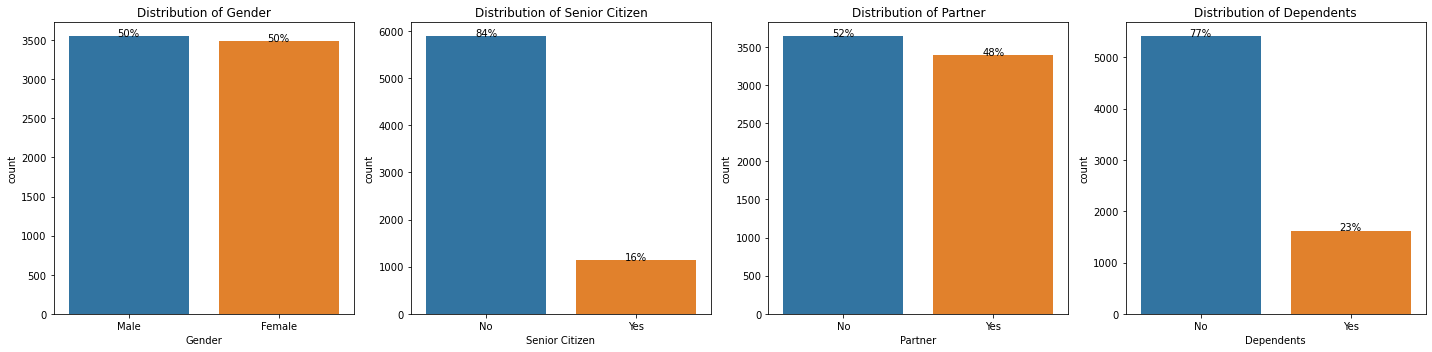

In [13]:
fig, ax = plt.subplots(nrows = 1,ncols = len(Demographic_group),figsize=(20,5))
data_cat_group = data.loc[:, Demographic_group]
for i, col in enumerate(Demographic_group):
    p = sns.countplot(x = col, data = data_cat_group, ax = ax[i])
    p.set_title(f"Distribution of {col}")
    add_perc_annotaions(p,col)
plt.tight_layout()
plt.show()

`Demographic_group`
- Equal distribution in **Gender**, and almost equal in **Partner**
- Most of our customers are not **Senior Citizen**, only 1/6 are Senior Citizen
- 2/3 of our customers are **Economic independents** and 1/3 of our customers are enconomic dependent

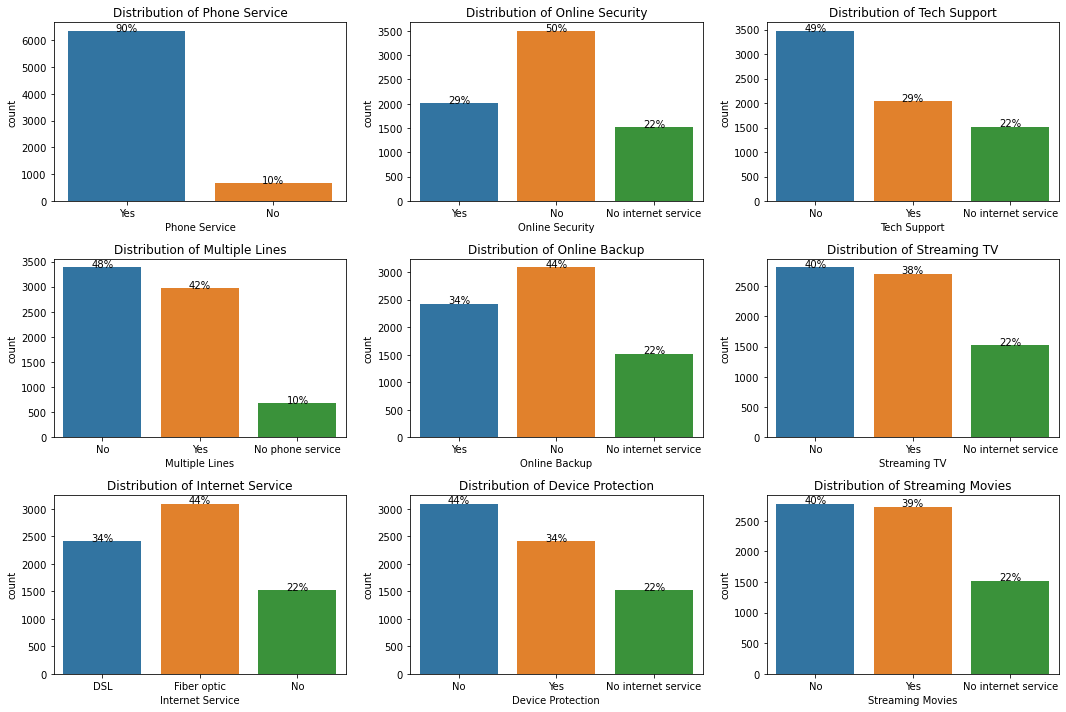

In [14]:
fig, ax = plt.subplots(nrows = 3,ncols = 3,figsize=(15,10))
data_cat_group = data.loc[:, Services_group]
for i, col in enumerate(Services_group):
    if i < 3:
        p = sns.countplot(x = col, data = data_cat_group, ax = ax[i,0])
    if i >= 3 and i < 6:
        p = sns.countplot(x = col, data = data_cat_group, ax = ax[i-3,1])
    if i >= 6:
        p = sns.countplot(x = col, data = data_cat_group, ax = ax[i-6,2])
    p.set_title(f"Distribution of {col}")
    add_perc_annotaions(p,col)
    
plt.tight_layout()
plt.show()

`Services_group`
- Most of our customers have used our **Phone Services**, among these customers, around 1/2 have **Multiple Lines**.
- 4/5 customers are using **Internet Service**, among these customers, around 1/3 have **Online Security** and **Tech Support**, around 1/2 have **Online Backup**, **Device Protection**, **Streaming TV** and **Streaming Movies**.

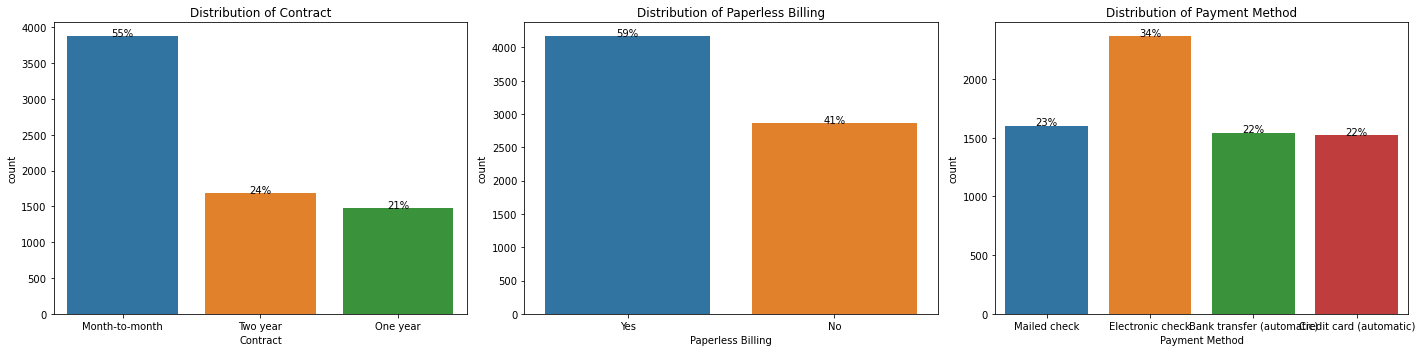

In [15]:
fig, ax = plt.subplots(nrows = 1,ncols = len(Customer_account_group),figsize=(20,5))
data_cat_group = data.loc[:, Customer_account_group]
for i, col in enumerate(Customer_account_group):
    p = sns.countplot(x = col, data = data_cat_group, ax = ax[i])
    p.set_title(f"Distribution of {col}")
    add_perc_annotaions(p,col)
    
plt.tight_layout()
plt.show()


`Customer_account_group`
- Around 1/2 customers signed month-to-month **Contract** with us.
- More customers are using **Paperless Billing**.
- More customers are going to pay with **Electronic check**.

### Explore Relationship between Categorical Data and Churn

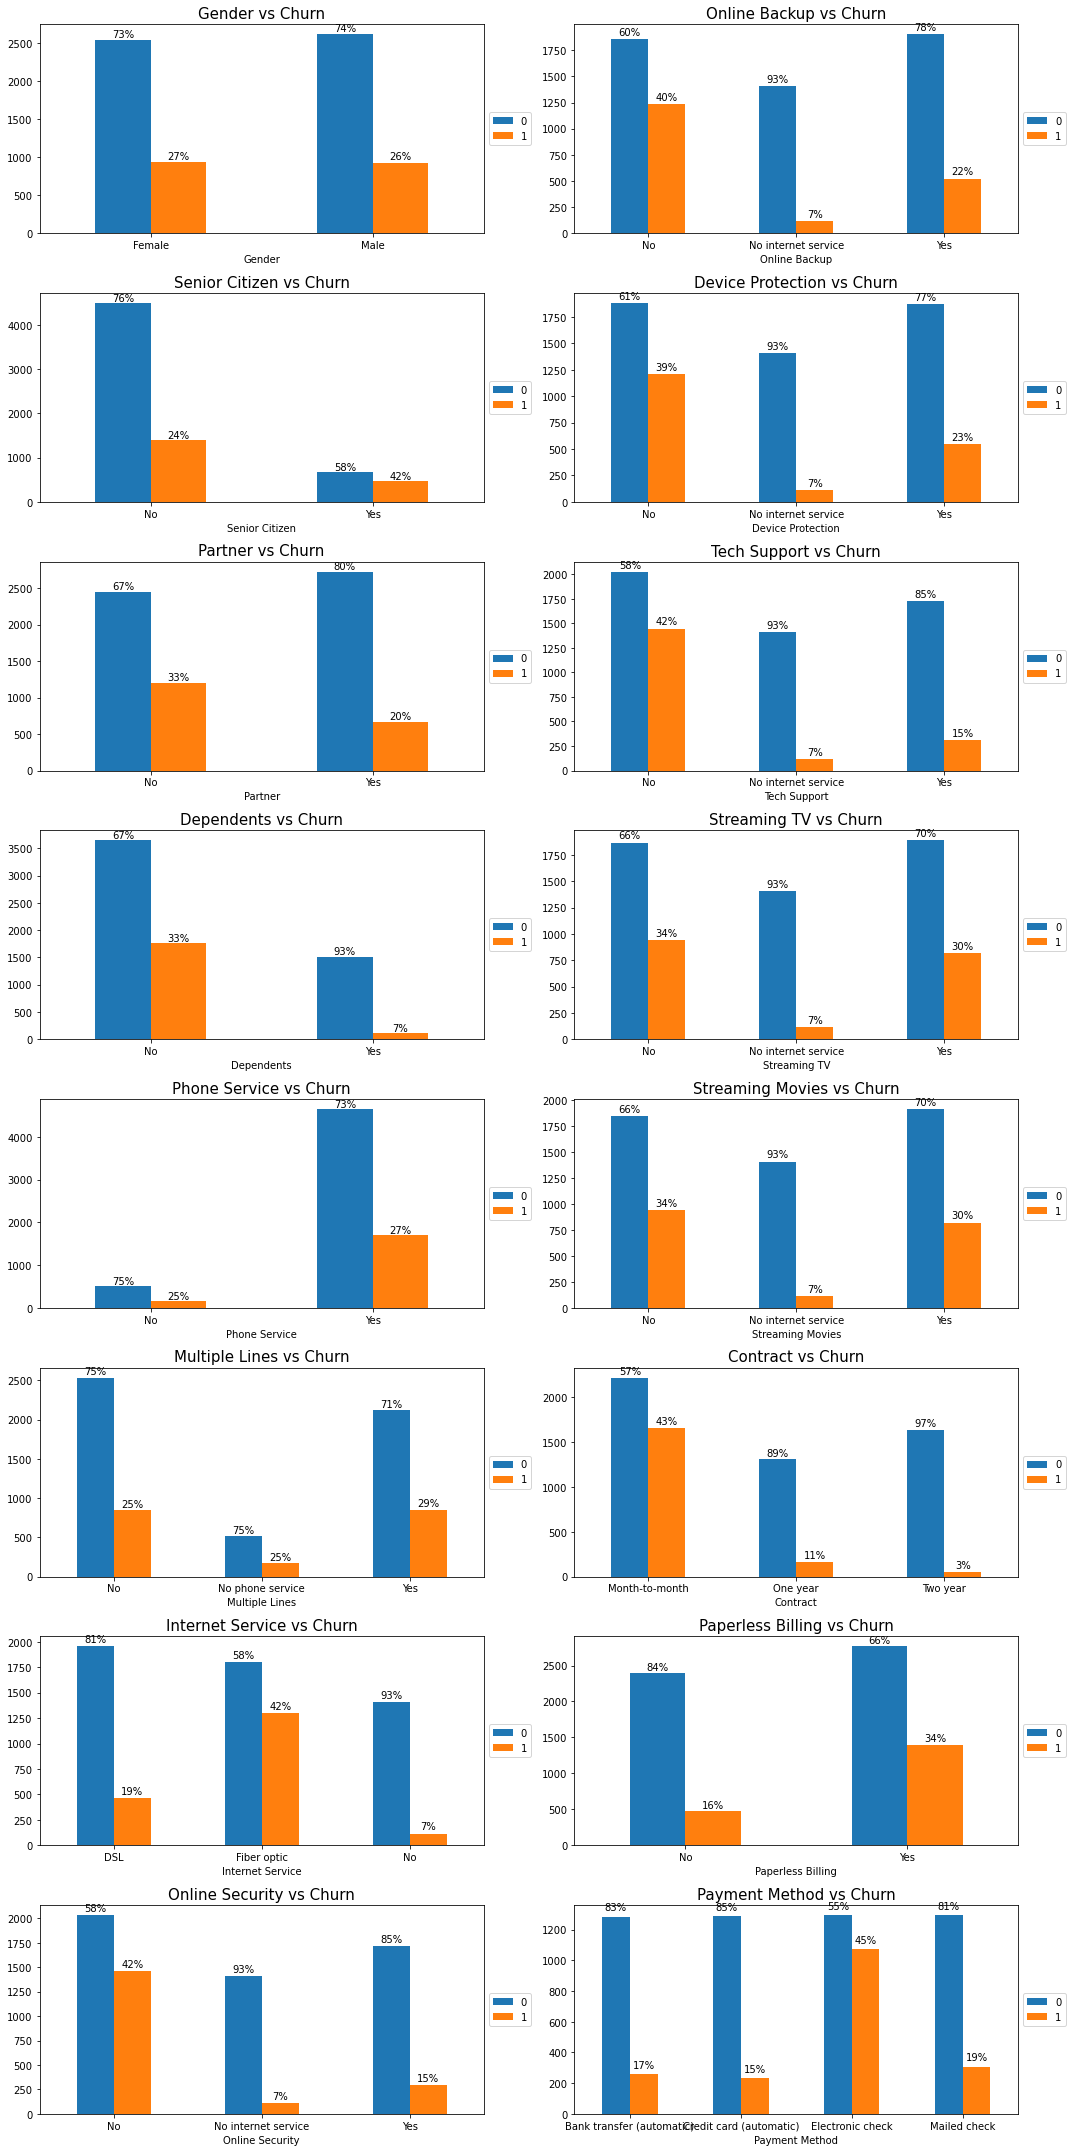

In [16]:
fig, axes = plt.subplots(nrows = 8,ncols = 2,figsize=(15,30))
for i, col in enumerate(cat_columns):
    Gender_group = data.groupby([col,'Churn Value']).size().unstack()
    if i < 8:
        p = Gender_group.plot.bar(ax=axes[i,0])
    if i >= 8:
        p = Gender_group.plot.bar(ax=axes[i-8,1])
    # Added annotation with percentage in hue
    bars = p.patches
    half = int(len(bars)/2)
    left_bars = bars[:half]
    right_bars = bars[half:]
    for left, right in zip(left_bars, right_bars):
        height_l = left.get_height()
        height_r = right.get_height()
        total = height_l + height_r
        p.text(left.get_x() + left.get_width()/2., height_l + 40, '{0:.0%}'.format(height_l/total), ha="center")
        p.text(right.get_x() + right.get_width()/2., height_r + 40, '{0:.0%}'.format(height_r/total), ha="center")
        
    p.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    p.set_title("{} vs Churn".format(col), fontsize=15)
    plt.setp(p.get_xticklabels(), rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

## Research Q1: Which services should company improve to avoid current customer leaving?

Conclusion:

`Demographic info`
- **Gender** is quite balaced in either churn or not. Thus Gender might not be a feature to affect the churn directly.
- **Senior Citizen** have a much higher churn rate
- Customers without **Partner** or **Dependents** are more likely to leave.

`Services`
- Customers with Fiber optic **Internet Service** are very likely to churn.
- Customers who doesn't sign up for **Online Security/Online Backup/Device Protection/Tech Support** are very likely to churn.
- **Streaming TV** and **Streaming Movies** are the most used service, but they're also the service with the highest customer churn rate.

`Customer account info`
- Customers with **Paperless Billing**/using **Electronic check Payment Method** are very likely to churn.
- The shorter the **Contract**, the higher the customer churn rate.

### Solution1
- Since customers with Fiber optic Internet Service are very likely to churn, the company should improve the Fiber optic technology and provide more DLS Internet Service advertisement currently.
- Since Senior Citizen have a much higher churn rate and there's a lower amount of customers, the company could provide some bonus or discount to those senior citizen.
- The company could encourage customers to sign up for Online Security/Online Backup/Device Protection/Tech Support since those who don't sign up are very likely to churn.
- Since customers without economic dependents are more likely to churn, the company could provide payment by installments program suggestions to those customers.
- Since customers using Electronic check Payment Method are very likely to churn, the company could suggest to customers to use credit card automatic as a default payment method that has lowest churn rate.
- Since month to month contract has much higer churn rate, the company could has a strategy to encourage customer to subscribe with years such as using high discount or adding bonus package.

### Explore Relationship between Numerical Data and Churn

In [17]:
data.describe()

,Tenure Months,Monthly Charges,Total Charges,Churn Value,CLTV
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441,0.265785,4401.445108
std,24.545260,30.085974,2266.771362,0.441782,1182.414266
min,1.000000,18.250000,18.800000,0.000000,2003.000000
25%,9.000000,35.587500,401.450000,0.000000,3469.750000
50%,29.000000,70.350000,1397.475000,0.000000,4527.500000
75%,55.000000,89.862500,3794.737500,1.000000,5381.000000
max,72.000000,118.750000,8684.800000,1.000000,6500.000000


The values on all columns distribution are looked reasonable and thus I won't replace or drop any values.

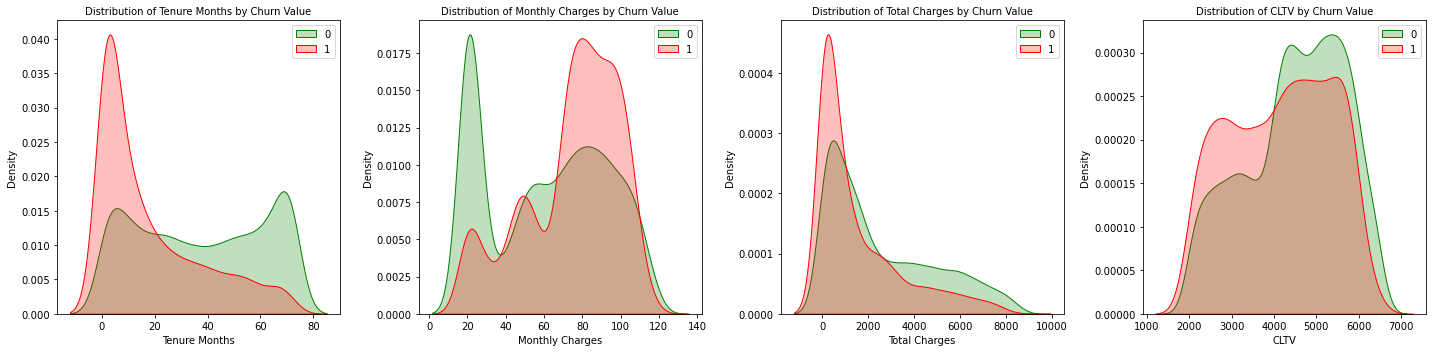

In [18]:
fig, ax = plt.subplots(nrows = 1,ncols = 4,figsize=(20,5))
numerical_columns = data.select_dtypes(include=np.number).columns.drop('Churn Value')
for i, col in enumerate(numerical_columns):
    ax[i].set_title(f"Distribution of {col} by Churn Value", fontsize = 10)
    item = data["Churn Value"].unique()
    sns.kdeplot(data[col][(data["Churn Value"] == 0) ], color = "green", shade = True, ax = ax[i])
    sns.kdeplot(data[col][(data["Churn Value"] == 1) ], ax = ax[i], color = "red", shade = True)
    ax[i].legend([0,1],loc='upper right')
    ax[i].set_ylabel('Density')
    ax[i].set_xlabel(col)
plt.tight_layout()
plt.show()

Conclusion:

`Tenure Months`
- Peak - Churn: around 5 months.
- There is a trend that the larger the tenure, the smaller the churn rate.

`Monthly Charges`
- Peak - Churn: around 80 dollars ;  Not Churn: around 20 dollars.
- The churn rate and monthly charges are not clearly related to each other.

`Total Charges`
- There is a trend that the larger the TotalCharges, the smaller the churn rate.

`CLTV`
- The churn rate and monthly charges are not clearly related to each other.

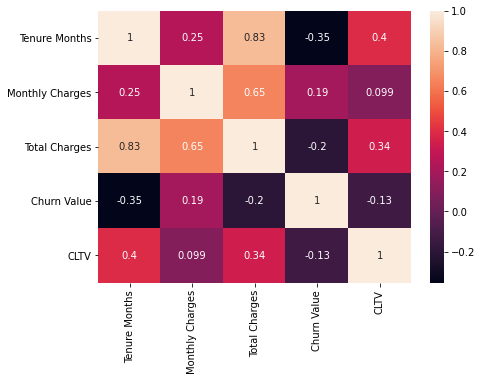

In [19]:
ax_corr = sns.heatmap(data.corr(), annot=True)

The correlation heat map shows `Total Charges` is correlated to `Tenure Months` and `Monthly Charges` but doesn't show these numerical columns have high correlation with `Churn value`

In [20]:
# label encoding all categorical columns
transform_dict = {}
for col in cat_columns:
    cats = pd.Categorical(data[col]).categories
    d = {}
    for i, cat in enumerate(cats):
        d[cat] = i
    transform_dict[col] = d
transform_dict

{'Gender': {'Female': 0, 'Male': 1},
 'Senior Citizen': {'No': 0, 'Yes': 1},
 'Partner': {'No': 0, 'Yes': 1},
 'Dependents': {'No': 0, 'Yes': 1},
 'Phone Service': {'No': 0, 'Yes': 1},
 'Multiple Lines': {'No': 0, 'No phone service': 1, 'Yes': 2},
 'Internet Service': {'DSL': 0, 'Fiber optic': 1, 'No': 2},
 'Online Security': {'No': 0, 'No internet service': 1, 'Yes': 2},
 'Online Backup': {'No': 0, 'No internet service': 1, 'Yes': 2},
 'Device Protection': {'No': 0, 'No internet service': 1, 'Yes': 2},
 'Tech Support': {'No': 0, 'No internet service': 1, 'Yes': 2},
 'Streaming TV': {'No': 0, 'No internet service': 1, 'Yes': 2},
 'Streaming Movies': {'No': 0, 'No internet service': 1, 'Yes': 2},
 'Contract': {'Month-to-month': 0, 'One year': 1, 'Two year': 2},
 'Paperless Billing': {'No': 0, 'Yes': 1},
 'Payment Method': {'Bank transfer (automatic)': 0,
  'Credit card (automatic)': 1,
  'Electronic check': 2,
  'Mailed check': 3}}

In [21]:
data_encoding = data[cat_columns].replace(transform_dict)
data_encoding

,Gender,Senior Citizen,Partner,Dependents,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method
0,1,0,0,0,1,0,0,2,2,0,0,0,0,0,1,3
1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,2
2,0,0,0,1,1,2,1,0,0,2,0,2,2,0,1,2
3,0,0,1,1,1,2,1,0,0,2,2,2,2,0,1,2
4,1,0,0,1,1,2,1,0,2,2,0,2,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,0,0,0,0,1,0,2,1,1,1,1,1,1,2,1,0
7028,1,0,1,1,1,2,0,2,0,2,2,2,2,1,1,3
7029,0,0,1,1,1,2,1,0,2,2,0,2,2,1,1,1
7030,0,0,1,1,0,1,0,2,0,0,0,0,0,0,1,2


In [22]:
# define standard scaler
scaler = MinMaxScaler()
# transform data
num_scaled = scaler.fit_transform(data[numerical_columns])
data_scaled = pd.DataFrame(num_scaled)
data_scaled.columns = numerical_columns
data_scaled

,Tenure Months,Monthly Charges,Total Charges,CLTV
0,0.014085,0.354229,0.010310,0.274850
1,0.014085,0.521891,0.015330,0.155215
2,0.098592,0.809950,0.092511,0.749166
3,0.380282,0.861194,0.349325,0.667111
4,0.676056,0.850249,0.578987,0.742050
...,...,...,...,...
7027,1.000000,0.028856,0.161620,0.734490
7028,0.323944,0.662189,0.227521,0.030465
7029,1.000000,0.845274,0.847461,0.790972
7030,0.140845,0.112935,0.037809,0.175673


In [23]:
Training_data = pd.concat([data_encoding, data_scaled], axis=1)
Training_data.head()

,Gender,Senior Citizen,Partner,Dependents,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Tenure Months,Monthly Charges,Total Charges,CLTV
0,1,0,0,0,1,0,0,2,2,0,0,0,0,0,1,3,0.014085,0.354229,0.010310,0.274850
1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,2,0.014085,0.521891,0.015330,0.155215
2,0,0,0,1,1,2,1,0,0,2,0,2,2,0,1,2,0.098592,0.809950,0.092511,0.749166
3,0,0,1,1,1,2,1,0,0,2,2,2,2,0,1,2,0.380282,0.861194,0.349325,0.667111
4,1,0,0,1,1,2,1,0,2,2,0,2,2,0,1,0,0.676056,0.850249,0.578987,0.742050


In [24]:
train_target = data['Churn Value']
train_target

0       1
1       1
2       1
3       1
4       1
       ..
7027    0
7028    0
7029    0
7030    0
7031    0
Name: Churn Value, Length: 7032, dtype: int64

In [25]:
# Splitting Dataset into train and test set
X = Training_data
y = train_target
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split( X, y, stratify=y, test_size=0.3, random_state=43)

(7032, 20) (7032,)


## Research Q2: What kind of services are more related to whether a customer leave?

### Using Chi-square testing for selecting categorical feature

In [26]:
bestfeatures = SelectKBest(score_func=chi2, k=4)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['element','Score']  #naming the dataframe columns
featureScores = featureScores.sort_values(by='Score', ascending=False) # set the order from high to low
featureScores.T

,13,7,10,3,16,8,9,1,14,2,18,15,17,19,5,6,12,11,0,4
element,Contract,Online Security,Tech Support,Dependents,Tenure Months,Online Backup,Device Protection,Senior Citizen,Paperless Billing,Partner,Total Charges,Payment Method,Monthly Charges,CLTV,Multiple Lines,Internet Service,Streaming Movies,Streaming TV,Gender,Phone Service
Score,1111.759054,550.437364,522.164716,333.236458,238.007569,229.441123,190.688004,133.482766,104.979224,81.857769,73.258486,59.240507,50.600233,14.991303,9.73596,9.715269,8.357624,7.373234,0.254297,0.092948


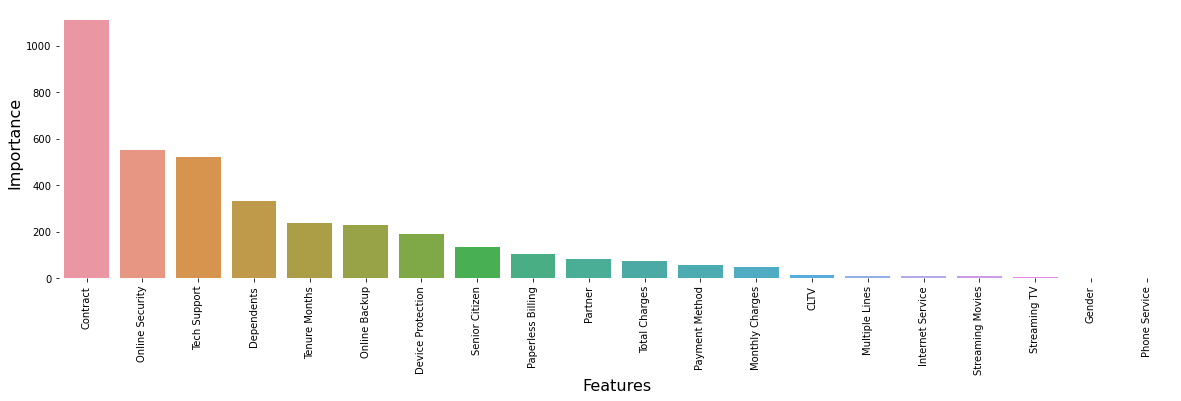

In [27]:
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
sns.barplot(x='element', y='Score', data= featureScores)
plt.box(False)
plt.xlabel('Features', fontsize=16)
plt.ylabel('Importance',fontsize=16)
plt.show()

In [28]:
high_chisquareScore_features = featureScores.element[:9].values
high_chisquareScore_features

array(['Contract', 'Online Security', 'Tech Support', 'Dependents',
       'Tenure Months', 'Online Backup', 'Device Protection',
       'Senior Citizen', 'Paperless Billing'], dtype=object)

### Check the correlation between features and label

<AxesSubplot:>

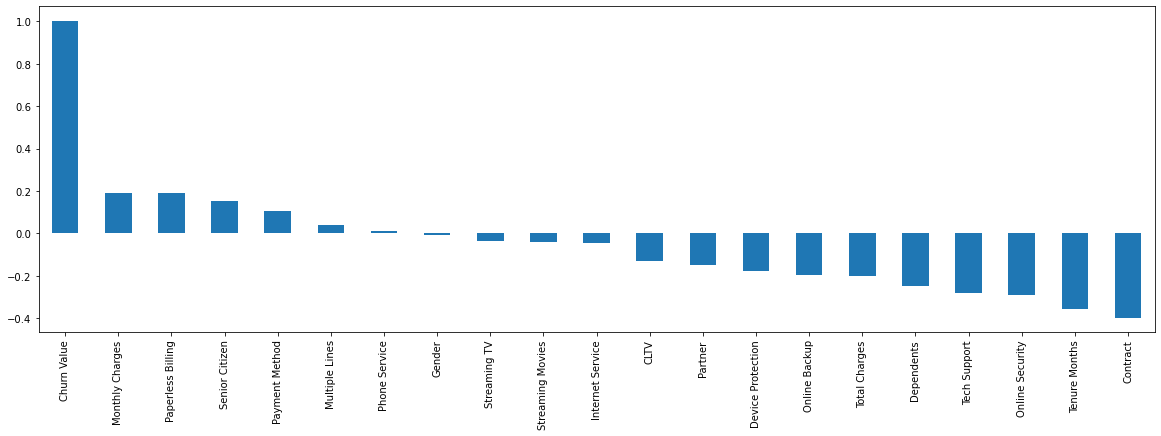

In [29]:
plt.figure(figsize=(20,6))
pd.concat([Training_data, train_target], axis=1).corr()['Churn Value'].sort_values(ascending = False).plot(kind='bar')

## Using lasso(L1) regularization to do the feature selection

In [30]:
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
                    ])
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error"
                      )
search.fit(X_train,y_train)
print('best_params_: ', search.best_params_)
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)
print('abs_coefficients',importance)
print('important features:', np.array(X.columns)[importance > 0])
print('not important features:\n', np.array(X.columns)[importance == 0])

best_params_:  {'model__alpha': 0.1}
abs_coefficients [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.06793702 0.         0.         0.00945736 0.
 0.         0.        ]
important features: ['Contract' 'Tenure Months']
not important features:
 ['Gender' 'Senior Citizen' 'Partner' 'Dependents' 'Phone Service'
 'Multiple Lines' 'Internet Service' 'Online Security' 'Online Backup'
 'Device Protection' 'Tech Support' 'Streaming TV' 'Streaming Movies'
 'Paperless Billing' 'Payment Method' 'Monthly Charges' 'Total Charges'
 'CLTV']


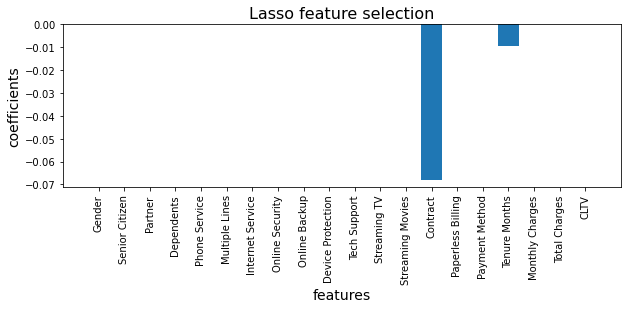

In [31]:
plt.figure(figsize=(10,3))
plt.bar(X.columns, coefficients)
plt.xticks(rotation='vertical')
plt.title('Lasso feature selection',fontsize=16)
plt.xlabel('features',fontsize=14)
plt.ylabel('coefficients',fontsize=14)
plt.show()

Conlusion:

Based on the chi squre test, correlation and Lasso feature selections, the highly important score and high correlation features show above **Contract, Tenure Months** are the most related features. **Online Security, Dependents and Tech Support** are also important. The company should pay more attention on those features first and come up with related strategy to reduce the Churn rate.

# 3. Building Models

### 1. Single Model for all features with Default Parameters

In [32]:
# define models
models = []
models.append(('LogisticRegression',LogisticRegression(random_state = 11)))
models.append(('RandomForest',RandomForestClassifier(random_state = 11)))
models.append(('Naive Bayes', GaussianNB()))
models.append(('KNeighbours', KNeighborsClassifier()))
#models.append(('SVM', SVC(probability=True)))

In [33]:
def evaluate_defalt_params(X_train, X_test, y_train, y_test, models):
    #Evaluating Model Results:
    acc_results = []
    auc_results = []

    # set table to table to populate with performance results
    col = ['Algorithm', 'Accuracy_test', 'Accuracy_best_train', 'Accuracy_mean_train', 'Accuracy_std_train', 'Running_time(s)']
    model_results = pd.DataFrame(columns=col)
    i = 0

    # using k-fold cross-validation:
    for name, model in models:
        start = time.time()
        kfold = KFold(n_splits=10, random_state=None)
        # accuracy scoring:
        cv_acc_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
        
        
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        test_score = np.round(accuracy_score(y_test,y_pred)*100, 2)
        
        end = time.time()
        run_time_train = int(end-start)
        
        model_results.loc[i] = [name,
                                round(test_score.max(), 2),
                                 round(cv_acc_results.max()*100, 2),
                                 round(cv_acc_results.mean()*100, 2),
                                 round(cv_acc_results.std()*100, 2),
                                 run_time_train
                                 ]
        
        i += 1
        
    model_results.sort_values(by=['Accuracy_test'], ascending=False)
    return model_results, y_pred



In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=43)
model_results_defalut, y_pred = evaluate_defalt_params(X_train, X_test, y_train, y_test, models)
model_results_defalut

,Algorithm,Accuracy_test,Accuracy_best_train,Accuracy_mean_train,Accuracy_std_train,Running_time(s)
0,LogisticRegression,81.18,84.35,81.31,2.03,0
1,RandomForest,79.48,82.32,80.27,1.85,6
2,Naive Bayes,75.64,79.31,76.61,2.07,0
3,KNeighbours,75.50,78.25,75.17,1.71,0


The default parameters model shows a good result on test and train accuracy but has a bit high standard error on train accuracy. Among those models, logistic regression has a best performance.

### 2. Single Model for all features with Tuning Parameters

In [35]:
# find out the parameter names based on the pipline function
for name, model in models:
    pipeline = Pipeline(steps = [['classifier', model]])
    print(name, ':\n', pipeline.get_params().keys(),'\n')

LogisticRegression :
 dict_keys(['memory', 'steps', 'verbose', 'classifier', 'classifier__C', 'classifier__class_weight', 'classifier__dual', 'classifier__fit_intercept', 'classifier__intercept_scaling', 'classifier__l1_ratio', 'classifier__max_iter', 'classifier__multi_class', 'classifier__n_jobs', 'classifier__penalty', 'classifier__random_state', 'classifier__solver', 'classifier__tol', 'classifier__verbose', 'classifier__warm_start']) 

RandomForest :
 dict_keys(['memory', 'steps', 'verbose', 'classifier', 'classifier__bootstrap', 'classifier__ccp_alpha', 'classifier__class_weight', 'classifier__criterion', 'classifier__max_depth', 'classifier__max_features', 'classifier__max_leaf_nodes', 'classifier__max_samples', 'classifier__min_impurity_decrease', 'classifier__min_impurity_split', 'classifier__min_samples_leaf', 'classifier__min_samples_split', 'classifier__min_weight_fraction_leaf', 'classifier__n_estimators', 'classifier__n_jobs', 'classifier__oob_score', 'classifier__random_

In [36]:
Logistic_params = {'classifier__penalty' : ['l1', 'l2'],
                   'classifier__C' : np.logspace(-4, 4, 20),
                   'classifier__solver' : ['liblinear']}

RandomForest_params = {"classifier__max_depth": [3, None],
                      "classifier__max_features": [1, 3, 10],
                      "classifier__min_samples_leaf": [1, 3, 10],
                      "classifier__criterion": ["gini", "entropy"]}

NB_params = {'classifier__var_smoothing': np.logspace(0,-9, num=100)}

KNN_params = {'classifier__n_neighbors': (1,10, 1),
              'classifier__leaf_size': (20,40,1),
              'classifier__p': (1,2),
              'classifier__weights': ('uniform', 'distance'),
              'classifier__metric': ('minkowski', 'chebyshev')}

## It takes 16 mins to run and don't have a better performance thus ignore it.
# SVM_params = {"classifier__kernel":["rbf", "poly"], 
#               "classifier__gamma": ["auto", "scale"], 
#               "classifier__degree":range(1,6,1)}

param_grid = [Logistic_params, RandomForest_params, NB_params, KNN_params]

In [37]:
#Evaluating Model Results:
def evaluation_tuning_params(X_train, X_test, y_train, y_test, models, param_grid):
    acc_results = []
    auc_results = []

    # set table to table to populate with performance results
    col = ['Algorithm', 'Accuracy_test', 'Accuracy_best_train', 'Accuracy_mean_train', 'Accuracy_std_train', 'Running_time(s)', 'Best_params']
    model_results = pd.DataFrame(columns=col)
    i = 0

    # using stratified k-fold cross-validation:
    for name, model in models:
        name = name + '_Tuning'
        ### train data evaluation
        start = time.time()
        pipeline = Pipeline(steps = [['scaler', MinMaxScaler()],
                                     ['classifier', model]])
        stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=11)   
        # Set the parameters by cross-validation
        grid_search_clf = GridSearchCV(estimator=pipeline,
                               param_grid=param_grid[i],
                               scoring='accuracy',
                               cv=stratified_kfold,
                               n_jobs=-1)
    
    
        grid_search_clf.fit(X_train, y_train)
        cv_train_best_params = grid_search_clf.best_params_
        print(f'\nBest_params in {name} model:\n', cv_train_best_params)
        cv_train_best_score = np.round(grid_search_clf.best_score_*100, 2)
        cv_train_means = np.round((grid_search_clf.cv_results_['mean_test_score']).mean()*100, 2)
        cv_train_stds = np.round((grid_search_clf.cv_results_['std_test_score']).mean(), 2)
        
        y_pred = grid_search_clf.predict(X_test)
        test_score = np.round(accuracy_score(y_test,y_pred)*100, 2)
        
        end = time.time()
        run_time_train = int(end-start)
        model_results.loc[i] = [name, test_score, cv_train_best_score, cv_train_means, cv_train_stds, run_time_train, cv_train_best_params]
        
        # Make the confusion matrix
        cf_matrix = confusion_matrix(y_test, y_pred)
        sns.heatmap(cf_matrix, annot=True, fmt="d", cmap='Blues')
        plt.title(f'{name} Model Test Confusion Matrix')
        plt.xlabel('Predicted', fontsize=12)
        plt.ylabel('True', fontsize=12)
        plt.show()
        
        # move to next model
        i += 1
        
    model_results = model_results.sort_values(by=['Accuracy_test'], ascending=False)
    return model_results, y_pred


Best_params in LogisticRegression_Tuning model:
 {'classifier__C': 0.615848211066026, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}


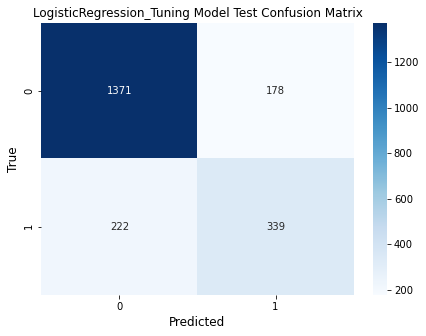


Best_params in RandomForest_Tuning model:
 {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__max_features': 10, 'classifier__min_samples_leaf': 10}


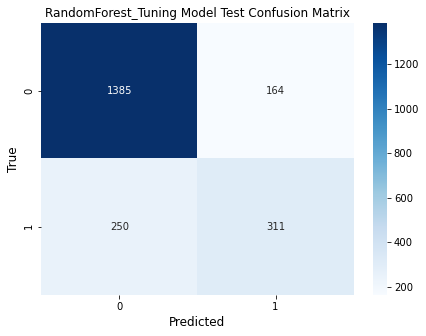


Best_params in Naive Bayes_Tuning model:
 {'classifier__var_smoothing': 1.0}


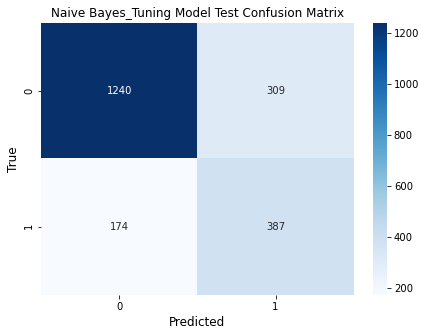


Best_params in KNeighbours_Tuning model:
 {'classifier__leaf_size': 20, 'classifier__metric': 'minkowski', 'classifier__n_neighbors': 10, 'classifier__p': 1, 'classifier__weights': 'uniform'}


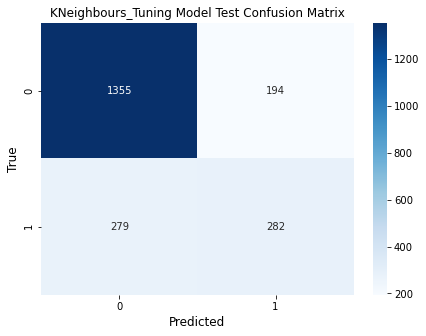

,Algorithm,Accuracy_test,Accuracy_best_train,Accuracy_mean_train,Accuracy_std_train,Running_time(s),Best_params
0,LogisticRegression_Tuning,81.04,81.27,79.17,0.01,8,"{'classifier__C': 0.615848211066026, 'classifi..."
1,RandomForest_Tuning,80.38,80.68,78.60,0.01,49,"{'classifier__criterion': 'entropy', 'classifi..."
3,KNeighbours_Tuning,77.58,77.47,73.20,0.02,20,"{'classifier__leaf_size': 20, 'classifier__met..."
2,Naive Bayes_Tuning,77.11,77.77,76.49,0.02,7,{'classifier__var_smoothing': 1.0}


In [38]:
model_results_tuning, y_pred = evaluation_tuning_params(X_train, X_test, y_train, y_test, models, param_grid)
model_results_tuning

Camparing to the defalut parameters, tuning parameters to train the data can improve the accuracy score specially for Random Forest and KNeighbours and Naive Bayes in both train and test data.

### 3. Hybrid Model combined PCA, Logistic Regression method with Tuning Parameters

In [39]:
# Doing scaler for the data
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

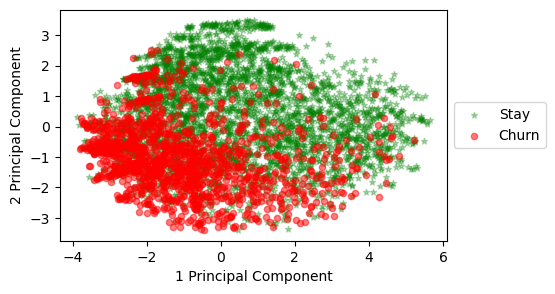

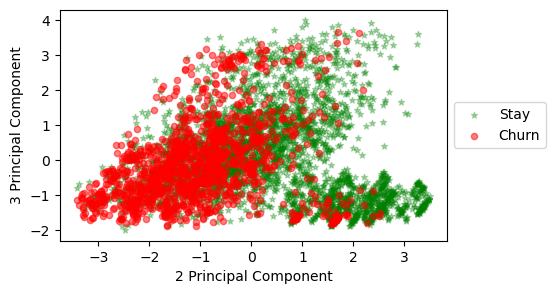

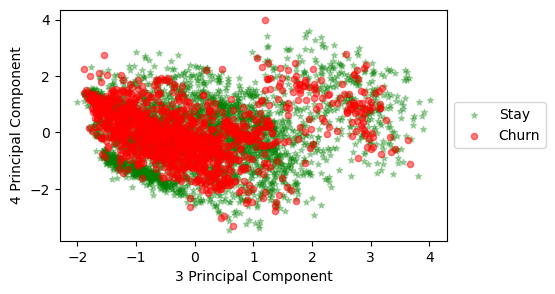

In [40]:
# shows the first four components distribution
plt.style.use('default')
for i in np.arange(0,3,1):
    # here use 20 components since there're 20 features in the dataset
    pca=PCA(n_components=20) 
    pca.fit(X_train_std) 
    X_pca=pca.transform(X_train_std) 
    Xax=X_pca[:,i]
    Yax=X_pca[:,i+1]
    color_dict={0:'green',1:'red'}
    labl={0:'Stay',1:'Churn'}
    marker={0:'*',1:'o'}
    alpha={0:.3, 1:.5}
    fig,ax=plt.subplots(figsize=(5,3))
    fig.patch.set_facecolor('white')
    for l in np.unique(y_train):
        ix=np.where(y_train==l)
        ax.scatter(Xax[ix],Yax[ix],c=color_dict[l],s=20,
               label=labl[l],marker=marker[l],alpha=alpha[l])
    # for loop ends
    plt.xlabel(f"{i+1} Principal Component",fontsize=10)
    plt.ylabel(f"{i+2} Principal Component",fontsize=10)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

We can see only 2 components clearly seperate the label of stay or churn. Others are bad. Thus component 3 should be enough to get a good variance ratio.

In [41]:
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print('Variance Ratio of 20 features:\n', np.round(var_exp,5))

Variance Ratio of 20 features:
 [0.21742 0.11548 0.07576 0.05918 0.05433 0.04996 0.04633 0.04386 0.04309
 0.041   0.03806 0.03595 0.03527 0.03378 0.02918 0.0276  0.02549 0.01586
 0.00976 0.00266]


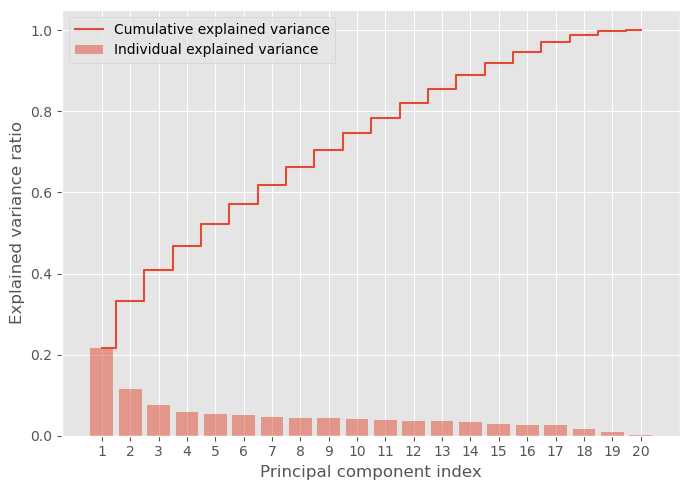

In [42]:
# plot the cumulative Variance Ratio
plt.figure(figsize=(7,5))
plt.style.use('ggplot')
plt.bar(range(1, len(var_exp)+1), var_exp, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, len(var_exp)+1), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.xticks(np.arange(1,21,1))
plt.legend(loc='best')
plt.tight_layout()
plt.show()

However, the cumulative ratio of two components is only 35%. Thus I'll select 11 components to be around 80% in hibrid model.

In [43]:
# find out the parameter names based on the pipline function
pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                            ['pca', PCA()],
                            ['classifier',LogisticRegression(random_state=11)]])
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'pca', 'classifier', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'classifier__C', 'classifier__class_weight', 'classifier__dual', 'classifier__fit_intercept', 'classifier__intercept_scaling', 'classifier__l1_ratio', 'classifier__max_iter', 'classifier__multi_class', 'classifier__n_jobs', 'classifier__penalty', 'classifier__random_state', 'classifier__solver', 'classifier__tol', 'classifier__verbose', 'classifier__warm_start'])

Best_params in PCA + LogisticRegression hibrid model:
 {'classifier__C': 0.012742749857031334, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'pca__n_components': 11}


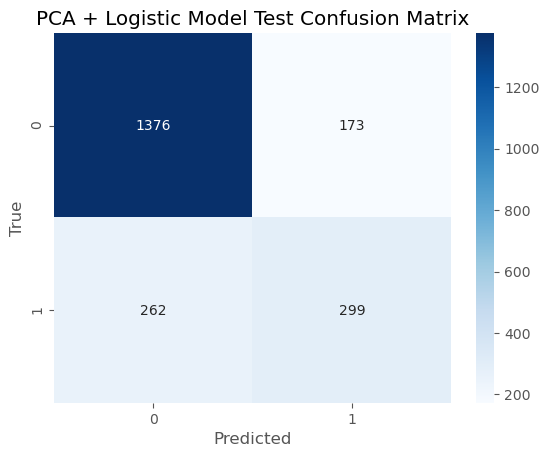

,Algorithm,Accuracy_test,Accuracy_best_train,Accuracy_mean_train,Accuracy_std_train,Running_time(s),Best_params
0,PCA+LogisticRegression,79.38,78.87,78.13,0.01,14,"{'classifier__C': 0.012742749857031334, 'class..."


In [44]:
params = {'pca__n_components':[11],
          'classifier__penalty' : ['l1', 'l2'],
           'classifier__C' : np.logspace(-4, 4, 20),
           'classifier__solver' : ['liblinear']}

start = time.time()
grid_search_hibrid_clf = GridSearchCV(pipeline, param_grid=params, cv=5)
grid_search_hibrid_clf.fit(X_train, y_train)
grid_search_hibrid_clf.fit(X_train, y_train)
cv_train_best_params = grid_search_hibrid_clf.best_params_
print('Best_params in PCA + LogisticRegression hibrid model:\n', cv_train_best_params)
cv_train_best_score = np.round(grid_search_hibrid_clf.best_score_*100, 2)
cv_train_means = np.round((grid_search_hibrid_clf.cv_results_['mean_test_score']).mean()*100, 2)
cv_train_stds = np.round((grid_search_hibrid_clf.cv_results_['std_test_score']).mean(), 2)

y_pred = grid_search_hibrid_clf.predict(X_test)
test_score = np.round(accuracy_score(y_test,y_pred)*100, 2)

end = time.time()
run_time_train = int(end-start)

# Make the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap='Blues')
plt.title(f'PCA + Logistic Model Test Confusion Matrix')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.show()

col = ['Algorithm', 'Accuracy_test', 'Accuracy_best_train', 'Accuracy_mean_train', 'Accuracy_std_train', 'Running_time(s)', 'Best_params']
model_results_hibrid = pd.DataFrame(np.array(['PCA+LogisticRegression', test_score, cv_train_best_score, cv_train_means, cv_train_stds, run_time_train, cv_train_best_params]).reshape(1,-1), columns=col)
model_results_hibrid


The Hibrid method also has a good Accuracy for train data, and the standard error is only 0.01. The accuracy for test data is higher than accuracy in train data. This is a good result.

### Combined all models results

In [45]:
model_results_defalut.append([model_results_tuning, model_results_hibrid])

,Algorithm,Accuracy_test,Accuracy_best_train,Accuracy_mean_train,Accuracy_std_train,Running_time(s),Best_params
0,LogisticRegression,81.18,84.35,81.31,2.03,0,NaN
1,RandomForest,79.48,82.32,80.27,1.85,6,NaN
2,Naive Bayes,75.64,79.31,76.61,2.07,0,NaN
3,KNeighbours,75.5,78.25,75.17,1.71,0,NaN
0,LogisticRegression_Tuning,81.04,81.27,79.17,0.01,8,"{'classifier__C': 0.615848211066026, 'classifi..."
1,RandomForest_Tuning,80.38,80.68,78.6,0.01,49,"{'classifier__criterion': 'entropy', 'classifi..."
3,KNeighbours_Tuning,77.58,77.47,73.2,0.02,20,"{'classifier__leaf_size': 20, 'classifier__met..."
2,Naive Bayes_Tuning,77.11,77.77,76.49,0.02,7,{'classifier__var_smoothing': 1.0}
0,PCA+LogisticRegression,79.38,78.87,78.13,0.01,14,"{'classifier__C': 0.012742749857031334, 'class..."


## Research Q3: Who are more likely to leave and what the confidence of that predictions are?

Based on the performance of all models, I'll select the LogisticRegression_Tuning as the best model to predict the current customers see who are more likely to leave.

Here we suppose current customer dataset are X, and we already split it to train and test data.

In [46]:
pipeline = Pipeline(steps = [['scaler', MinMaxScaler()], ['classifier', LogisticRegression(random_state = 11)]])
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=11)   
# Set the parameters by cross-validation
grid_search_clf = GridSearchCV(estimator=pipeline,
                       param_grid=Logistic_params,
                       scoring='accuracy',
                       cv=stratified_kfold,
                       n_jobs=-1)

grid_search_clf.fit(X_train, y_train)
y_pred = grid_search_clf.predict(X_test)
y_pred_prob = grid_search_clf.predict_proba(X_test)

In [47]:
df_y_pred = pd.DataFrame(y_pred,columns=['Pred_label'],index=y_test.index)
df_y_pred['Pred_confidence(%)'] = np.round(y_pred_prob[:,1]*100,2)
df_y_pred = pd.concat([df_churn[df_churn.index.isin(y_test.index)]['CustomerID'],df_y_pred],axis=1)
df_y_pred

,CustomerID,Pred_label,Pred_confidence(%)
0,3668-QPYBK,0,36.56
1,9237-HQITU,0,27.15
8,6467-CHFZW,0,20.57
11,6047-YHPVI,0,23.81
14,7760-OYPDY,0,33.94
...,...,...,...
7025,8456-QDAVC,1,54.21
7026,7750-EYXWZ,0,29.55
7027,2569-WGERO,0,0.40
7028,6840-RESVB,0,6.48


In [48]:
df_Churn = df_y_pred[df_y_pred['Pred_label']==1]
df_Churn

,CustomerID,Pred_label,Pred_confidence(%)
63,7273-TEFQD,1,73.08
64,3606-TWKGI,1,76.95
66,4385-GZQXV,1,62.03
67,6366-ZGQGL,1,53.01
68,5940-AHUHD,1,56.30
...,...,...,...
6921,7952-OBOYL,1,63.18
6923,7853-OETYL,1,62.59
7010,0666-UXTJO,1,58.10
7018,2823-LKABH,1,57.52


In [49]:
More_likely_churn = df_Churn[df_Churn['Pred_confidence(%)']>=80]
print(f'There are {len(df_y_pred)} customers currently in the test dataset.\n\
There are {len(df_Churn)} ({int(len(df_Churn)/len(df_y_pred)*100)}%) customers might be churn,\n\
{len(More_likely_churn)} customers among of them have more than 80% confidence that more likely to churn.\n')
More_likely_churn

There are 2110 customers currently in the test dataset.
There are 517 (24%) customers might be churn,
34 customers among of them have more than 80% confidence that more likely to churn.



,CustomerID,Pred_label,Pred_confidence(%)
77,8098-LLAZX,1,83.44
146,5192-EBGOV,1,81.15
159,1626-ERCMM,1,80.80
178,4952-YSOGZ,1,83.47
298,7851-WZEKY,1,81.84
300,4086-YQSNZ,1,80.52
373,7024-OHCCK,1,83.94
419,3068-OMWZA,1,80.00
584,7216-EWTRS,1,89.19
738,4102-OQUPX,1,81.94


# Conclusion:

This project has solved the Research Questions about:
- Research Q1: Which services should company improve to avoid current customer leaving?
- Research Q2: What kind of services are more related to whether a customer leave?
- Research Q3: Who are more likely to leave and what the confidence of that predictions are?

Based on the solutions of those questions, the company are now able to make some relevant strategies to improve their services and knowing who are more likely to leave now thus this research  can help company reduce the churn rate of their customers to increase the profit.

# Reference: 

https://www.sciencedirect.com/science/article/abs/pii/S0148296321000308

https://content.iospress.com/articles/journal-of-intelligent-and-fuzzy-systems/ifs190677

https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn

https://stackoverflow.com/questions/45969390/difference-between-stratifiedkfold-and-stratifiedshufflesplit-in-sklearn

https://towardsdatascience.com/gridsearchcv-for-beginners-db48a90114ee

https://joannaoyzl.github.io/2019/07/28/Unsupervised-Learning-in-Python/
